# Innovation Degree of Freedom
       This file calculates the degree of freedom of innovation (defined as Num(immediate potential objects can be made) - Num(objs already made)) at different time points in the family history
   
   Created by Grace Deng in August, 2020

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

load empowerment dictionary

In [2]:
with open('../3_technology/tech_outputs/products.txt') as json_file:
    emp = json.load(json_file)

In [3]:
emp = {int(k): v for k, v in emp.items() if len(v)!= 0}

load map change data

In [4]:
data = pd.read_csv('../2_demographics/outputs/parsed_map_change.csv', index_col = [0])

In [5]:
data = data.sort_values(by = 'time')

In [6]:
data.head()

,time,locX,locY,obj,playerID,family
0,122.31,-5137,-1395,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
1,125.06,-5138,-1394,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
2,127.21,-5138,-1395,236,2276905,time-1573895755_eve-2276905_name-ZABICKI
3,129.09,-5135,-1396,134,2276905,time-1573895755_eve-2276905_name-ZABICKI
4,130.33,-5136,-1395,0,2276905,time-1573895755_eve-2276905_name-ZABICKI


In [7]:
len(data)

840408

find object and family index

In [8]:
data['cum_obj_num'] = data.groupby('family')['obj'].cumcount()

In [9]:
data['fam_idx'] = data.groupby('family',as_index = False).ngroup()

In [10]:
obj_list = data.groupby('family')['obj'].apply(list).to_list()

In [11]:
len(obj_list)

48

tag cumulative objects up to time t

In [13]:
data['cum_objs'] = data.apply(lambda x: set(obj_list[x.fam_idx][0:x.cum_obj_num+1]), axis = 1)

In [14]:
data.head()

,time,locX,locY,obj,playerID,family,cum_obj_num,fam_idx,cum_objs
0,122.31,-5137,-1395,0,2276905,time-1573895755_eve-2276905_name-ZABICKI,0,0,{0}
1,125.06,-5138,-1394,0,2276905,time-1573895755_eve-2276905_name-ZABICKI,1,0,{0}
2,127.21,-5138,-1395,236,2276905,time-1573895755_eve-2276905_name-ZABICKI,2,0,"{0, 236}"
3,129.09,-5135,-1396,134,2276905,time-1573895755_eve-2276905_name-ZABICKI,3,0,"{0, 236, 134}"
4,130.33,-5136,-1395,0,2276905,time-1573895755_eve-2276905_name-ZABICKI,4,0,"{0, 236, 134}"


take only rows where new objects are made

In [15]:
data_unique = data.copy()

In [16]:
data_unique['num_obj'] = data_unique['cum_objs'].apply(lambda x: len(x))

In [17]:
data_new = data_unique.groupby(['family', 'num_obj'])[['time', 'cum_objs']].apply(min).reset_index()

In [18]:
data_new.head()

,family,num_obj,time,cum_objs
0,time-1573895755_eve-2276905_name-ZABICKI,1,122.31,{0}
1,time-1573895755_eve-2276905_name-ZABICKI,2,127.21,"{0, 236}"
2,time-1573895755_eve-2276905_name-ZABICKI,3,129.09,"{0, 236, 134}"
3,time-1573895755_eve-2276905_name-ZABICKI,4,172.11,"{0, 2873, 236, 134}"
4,time-1573895755_eve-2276905_name-ZABICKI,5,175.11,"{0, 134, 236, 2742, 2873}"


In [19]:
len(data_new)

15277

find innovation degree of freedom

In [35]:
def find_emp(objs):
    tot = objs
    for i in objs:
        if i in emp.keys():
            tot = np.append(tot, [i for i in emp[i] if i not in tot])
    tot = [i for i in tot if i not in objs]
    return len(tot)

In [ ]:
data_new['degree_of_freedom'] = data_new['cum_objs'].apply(find_emp)

In [ ]:
data_new.head()

,family,num_obj,time,cum_objs,degree_of_freedom
0,time-1573895755_eve-2276905_name-ZABICKI,1,122.31,{0},0
1,time-1573895755_eve-2276905_name-ZABICKI,2,127.21,"{0, 236}",30
2,time-1573895755_eve-2276905_name-ZABICKI,3,129.09,"{0, 236, 134}",34
3,time-1573895755_eve-2276905_name-ZABICKI,4,172.11,"{0, 2873, 236, 134}",35
4,time-1573895755_eve-2276905_name-ZABICKI,5,175.11,"{0, 134, 236, 2742, 2873}",35


save data

In [39]:
data_new.to_csv('empowerment_dynamic.csv')

plot innovation_df against time (one family)

In [52]:
myfam = data_new.family.unique()[2]
myfam

'time-1573896101_eve-2276917_name-BADA'

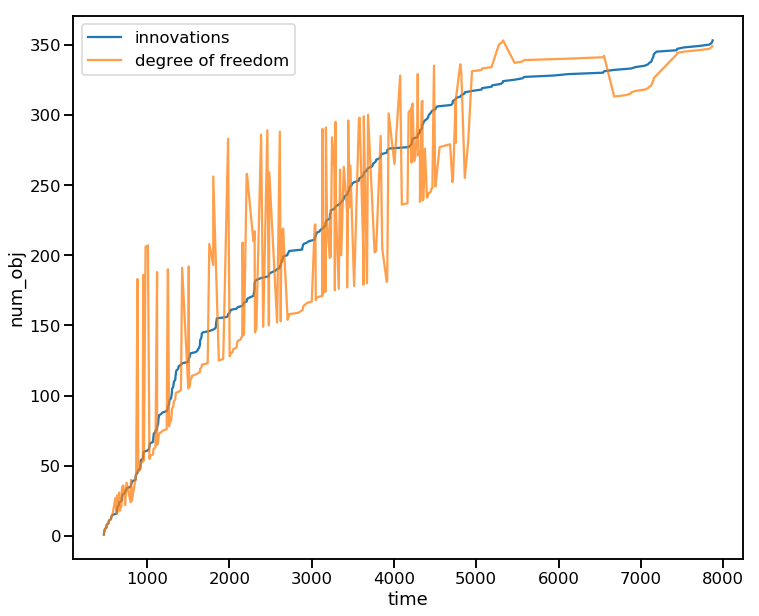

In [59]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize = (12,10))
sns.lineplot(data = data_new.loc[data_new.family == myfam], x = 'time', y = 'num_obj', label = 'innovations')
# sns.lineplot(data = data_new, x = 'time', y = 'degree_of_freedom', hue = 'family')
sns.lineplot(data = data_new.loc[data_new.family == myfam], x = 'time', y = 'degree_of_freedom', alpha = 0.75, label = 'degree of freedom')
plt.savefig('innovation&df_growth', dpi = 100, transparent = True)
# plt.show()

What's the highest innovation_df for each family?

In [34]:
test = data_new.groupby('family')['degree_of_freedom'].apply(max).to_frame().reset_index()

In [35]:
test

,family,degree_of_freedom
0,time-1573895755_eve-2276905_name-ZABICKI,1104
1,time-1573895904_eve-2276911_name-ROHRER,267
2,time-1573896101_eve-2276917_name-BADA,1079
3,time-1573896134_eve-2276919_name-SARINA,1128
4,time-1573896495_eve-2276927_name-LISSADE,1154
5,time-1573905001_eve-2277238_name-NORTH,381
6,time-1573906131_eve-2277285_name-NEW,176
7,time-1573907431_eve-2277342_name-FINCH,1170
8,time-1573909483_eve-2277421_name-ISPAS,1128
9,time-1573913113_eve-2277579_name-IN,225
